<div class="alert alert-block alert-success">
     
# IC PCDA CAPSTONE - HARRY BAKHSHI - NOTEBOOK 7 - FORECASTABILITY OF DATA
     
</div>

MIT License for code used from https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python in notebook:   
https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python?tab=MIT-1-ov-file     

(Accessed 06/06/2024)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"
import pandas as pd
import pickle
import statistics
from darts.models import Theta
from darts.utils.utils import ModelMode, SeasonalityMode

Load timeseries and seasonal period list:

In [40]:
#Import timeseries data and seasonal period list:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/outlier_treated_ts_df_2.pik'
# with open(file, 'wb') as f:
#        pickle.dump(ts_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     ts_df = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_variable_seasonal_period_list_2.pik'
# with open(file, 'wb') as f:
#     pickle.dump(seasonal_period_list, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     seasonal_period_list = pickle.load(f) #load pickle file 'file' into variable

Create function for formatting ploty plots:

In [41]:
#Create function for formatting ploty plots:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter04/02-Baseline%20Forecasts%20using%20darts.ipynb
#Accessed 17/06/2024

Create function to make time series stationary:

In [42]:
#Create functions to make time series stationary:
from functools import partial
import statsmodels.api as sm

def _detrend(x, lo_frac=0.6, lo_delta=0.01, return_trend=False):
    # use some existing pieces of statsmodels
    lowess = sm.nonparametric.lowess
    # get plain np array
    observed = np.asanyarray(x).squeeze()
    # calc trend, remove from observation
    trend = lowess(
        observed,
        [x for x in range(len(observed))],
        frac=lo_frac,
        delta=lo_delta * len(observed),
        return_sorted=False,
    )
    detrended = observed - trend
    return detrended, trend if return_trend else detrended

def make_stationary(x: np.ndarray, method: str="detrend", detrend_kwargs:dict={}):
    """Utility to make time series stationary

    Args:
        x (np.ndarray): The time series array to be made stationary
        method (str, optional): {"detrend","logdiff"}. Defaults to "detrend".
        detrend_kwargs (dict, optional): These kwargs will be passed on to the detrend method
    """
    if method=="detrend":
        detrend_kwargs["return_trend"] = True
        stationary, trend = _detrend(x, **detrend_kwargs)
        def inverse_transform(st, trend):
            return st+trend
        return stationary, partial(inverse_transform, trend=trend)
    elif method == "logdiff":
        stationary = np.log(x[:-1]/x[1:])
        def inverse_transform(st, x):
            _x = np.exp(st)
            return _x*x[1:]
        return stationary, partial(inverse_transform, x=x)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/utils/ts_utils.py
#Accessed 02/07/2024

Create functions to calculate Coefficient of Variation and Residual Variability:

In [43]:
#Create functions to calculate Coefficient of Variation and Residual Variability:
import warnings
def calc_norm_sd(x, original):
    if (len(x) <= 2) and np.all(x == 0):
        warnings.warn(
            "Array should not be all zeroes or should atleast more than 1 datapoint. COV will be NaN"
        )
        cov = np.nan
    else:
        cov = np.std(x) / np.mean(original)
    return cov
def calc_cov(x):
    if (len(x) <= 2) and np.all(x == 0):
        warnings.warn(
            "Array should not be all zeroes or should atleast more than 1 datapoint. COV will be NaN"
        )
        cov = np.nan
    else:
        cov = np.std(x) / np.mean(x)
    return cov
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/cov.py
#Accessed 02/07/2024

# Calculate Forecastability Metrics

In [44]:
col_list = list(ts_df.columns.values[:140])
# drop_list = []
# for col in range(len(col_list)):
#     for row in range(len(ts_df)):
#         val = ts_df.iloc[row, col]
#         if pd.isnull(val):
#             drop_list.append(ts_df.columns.values[1+col])
# ts_df = ts_df.drop(drop_list, axis=1, inplace=True)
print(len(col_list))
print(len(seasonal_period_list))

140
140


Make variables stationary:

In [45]:
#Make variables stationary:
for var in range(len(col_list)):
# for var in range(1):
    if seasonal_period_list[var] != 'not seasonal':
        file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions/seasonal_decomposition_fit_'
        file_edit = file
        file_to_use = file_edit + str(col_list[var]) + '.pik'
        #^https://www.datacamp.com/tutorial/python-append-string#
        # #Accessed 12/06/2024
        with open(file_to_use, 'rb') as f:
            pickle_var = pickle.load(f) #load pickle file 'file' into variable
        pickle_var = np.array(pickle_var.resid.values)
        temp = make_stationary(pickle_var)
        new_pickle_var = pd.Series(temp[0])
        new_pickle_var.name = str(col_list[var])
        if var == 0:
            next_pickle = new_pickle_var
        else:
            next_pickle = pd.concat([next_pickle, new_pickle_var], axis=1)
    else:
        temp = _detrend(ts_df[col_list[var]])
        temp = temp[0]
        ts_df[col_list[var]] = pd.Series(temp, index=ts_df.index)
        ts_df[col_list[var]].name = str(col_list[var])
residuals_df = next_pickle

In [46]:
residuals_df

,679023median_total_price,245338median_total_price,222087median_total_price,378934median_total_price,219029median_total_price,219009median_total_price,216425median_total_price,216419median_total_price,327492median_total_price,300291median_total_price,...,222087percent_display,222765percent_display,378934percent_display,219029percent_display,216418percent_display,320485percent_display,217217percent_display,600934percent_display,673209percent_display,546789percent_display
0,-7.38129,27.969445,30.672361,20.797262,-5.181933,-4.186256,4.739736,-3.041333,-35.077491,-43.349311,...,-0.031662,0.075918,0.085302,0.033141,-0.091945,-0.018745,-0.035021,-0.006744,0.219363,0.475586
1,-4.162351,-4.176593,2.667301,3.542558,8.992578,-3.552119,9.540746,8.321094,8.124942,42.892716,...,-0.026487,-0.022622,0.098387,0.050096,0.029033,-0.006355,0.11771,-0.103597,-0.221709,-0.077613
2,-6.117284,-11.593419,0.698493,2.898509,20.609730,7.235364,10.173235,4.644425,-57.592140,-61.879550,...,0.271741,-0.013815,0.032259,-0.020800,0.132909,0.001571,0.044245,-0.135823,-0.185739,0.080303
3,-9.76902,-0.922012,43.544076,-2.071131,29.690544,9.896182,8.108278,2.394208,-57.752078,-57.509440,...,0.035854,-0.001437,0.032932,-0.143698,0.050355,-0.004346,0.016958,-0.157605,-0.161314,-0.066777
4,-10.38059,-9.185015,-1.321034,-7.991797,-32.511867,-40.366475,5.692702,2.121707,-58.288115,-61.440921,...,-0.004788,0.092130,0.145529,0.156706,0.041237,-0.023925,-0.004504,0.200455,0.096914,-0.023892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-3.608032,11.529643,1.431533,-1.757071,-42.651359,-1.023467,2.273748,0.814936,-10.211128,-17.858262,...,0.000996,-0.008460,0.038933,0.216648,0.038838,0.00709,0.01577,0.062735,-0.181348,0.052070
148,-3.602914,55.257994,-6.310461,-2.111310,0.948802,-8.328655,2.027295,1.180772,-5.092532,-5.816343,...,0.001225,-0.005412,0.041696,-0.061834,0.026833,0.006885,0.015418,0.048527,-0.185006,0.152701
149,-3.59723,27.021181,-6.290381,-2.545287,0.540773,-17.900037,-2.369292,0.459346,-5.094765,-5.334427,...,0.001455,-0.001347,0.045304,-0.061870,0.039640,0.006678,0.015064,0.050917,-0.020344,0.010416
150,-3.590965,24.577127,-15.085502,-2.967721,0.141062,-11.545253,-1.545592,1.166406,-3.893804,-3.524937,...,0.001687,0.014560,0.058226,-0.061908,0.042528,0.006468,0.014708,0.053224,-0.188961,0.011000


## Coefficient of Variation (CV)

Calculate and plot CV

/tmp/ipykernel_40627/1370289694.py:19: RuntimeWarning:

invalid value encountered in scalar divide



No. included:  61
No. original:  91


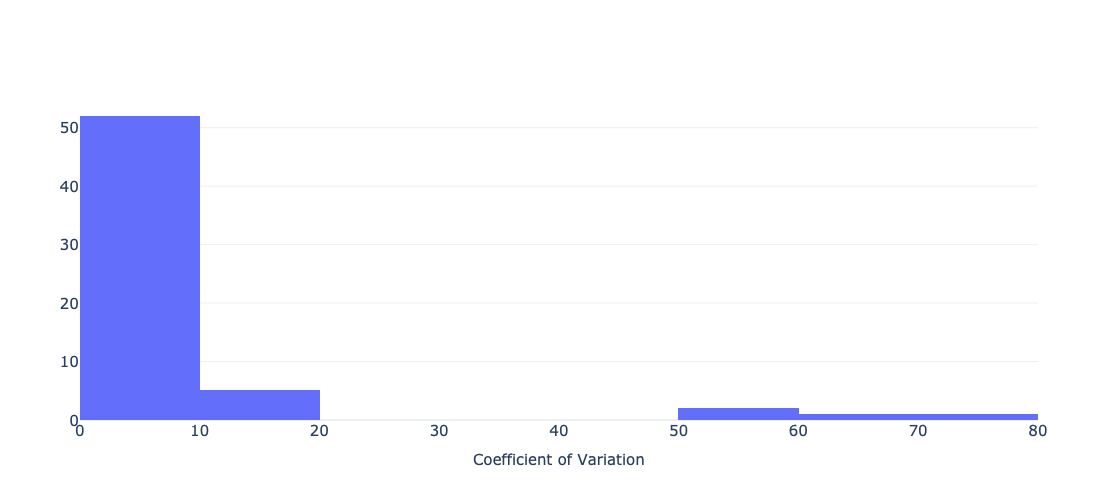

In [47]:
#Calculate and plot CV
cov_list = []
for var in range(len(col_list)):
    if col_list[var] not in list(residuals_df.columns.values):
        cov = calc_cov(ts_df[col_list[var]])
        cov_list.append(cov)
    else:
        cov_list.append('a')
orig_cov_list = cov_list.copy()
for ele in range(len(cov_list)):
    if cov_list[ele] == 'a':
        cov_list[ele] = np.nan
for ele in range(len(cov_list)):
    if cov_list[ele] > 100:
        cov_list[ele] = np.nan
    if cov_list[ele] < 0:
        cov_list[ele] = np.nan
cov_series_init = pd.Series(cov_list)
cov_list = []
cov_drop_list = []
for ele in range(len(cov_series_init)):
    val = cov_series_init.iloc[ele]
    if not pd.isnull(val):
        cov_list.append(val)
    else:
        cov_drop_list.append(ele)
cov_series = pd.Series(cov_list)
print('No. included: ', len(cov_list))
print('No. original: ', (len(cov_series_init) - len(list(residuals_df.columns.values))))
fig = px.histogram(x=cov_series, title="Distribution of Coefficient of Variation")
fig = format_plot(fig, xlabel="Coefficient of Variation", ylabel="")
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_CV.png")
fig.show()

## Residual Variability (RV)

Calculate and plot RV

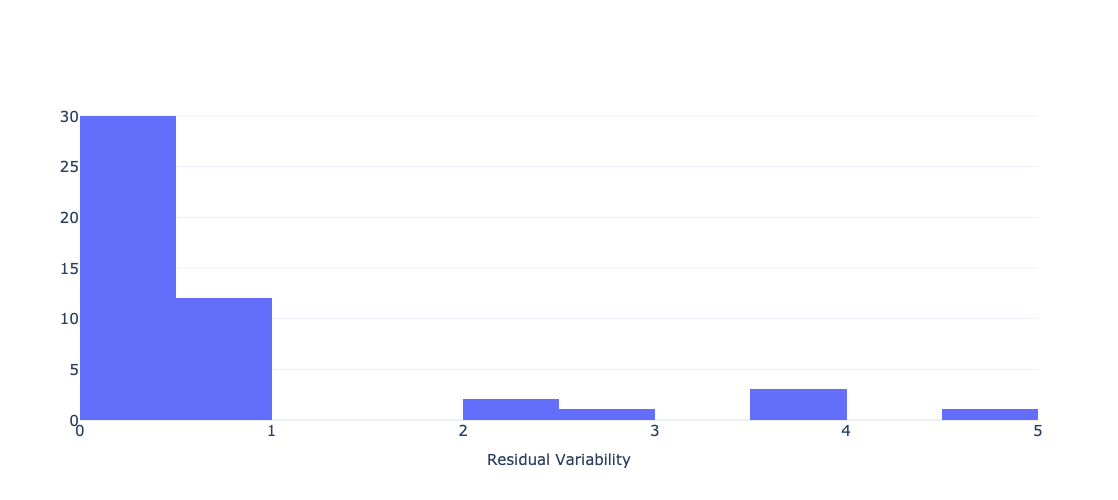

No. included:  49
No. original:  49


In [48]:
#Calculate and plot RV
rv_list = []
for var in range(len(col_list)):
    if seasonal_period_list[var] != 'not seasonal':
        index = list(residuals_df.columns.values).index(col_list[var])
        rv = calc_norm_sd(residuals_df[residuals_df.columns.values[index]], ts_df[col_list[var]])
        rv_list.append(rv)
    else:
        rv_list.append('a')
orig_rv_list = rv_list.copy()
for ele in range(len(rv_list)):
    if rv_list[ele] == 'a':
        rv_list[ele] = np.nan
for ele in range(len(rv_list)):
    if rv_list[ele] > 100:
        rv_list[ele] = np.nan
    if rv_list[ele] < 0:
        rv_list[ele] = np.nan
rv_series_init = pd.Series(rv_list)
rv_list = []
rv_drop_list = []
for ele in range(len(rv_series_init)):
    val = rv_series_init.iloc[ele]
    if not pd.isnull(val):
        rv_list.append(val)
    else:
        rv_drop_list.append(ele)
rv_series = pd.Series(rv_list)
fig = px.histogram(x=rv_series, title="Distribution of Residual Variability")
fig = format_plot(fig, xlabel="Residual Variability", ylabel="")
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_RV.png")
fig.show()
print('No. included: ', len(rv_list))
print('No. original: ', (len(rv_series_init) - (len(col_list) - len(list(residuals_df.columns.values)))))

## Spectral Entropy

Calculate and plot Spectral Entropy:

No. included:  78
No. original:  91


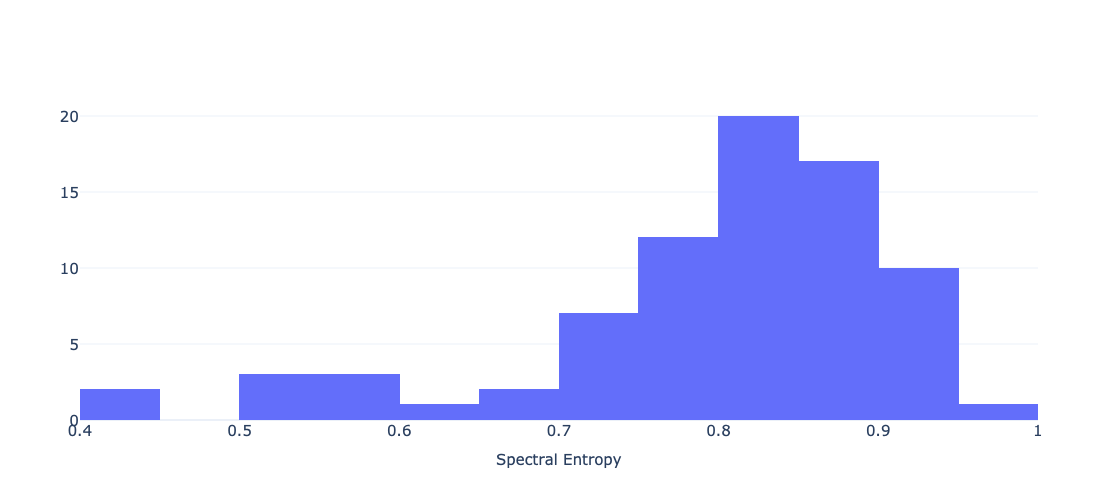

In [11]:
#Calculate and plot Spectral Entropy:
from src.forecastability.entropy import spectral_entropy
import cmath
spe_list = []
for var in range(len(col_list)):
    if col_list[var] not in list(residuals_df.columns.values):
        med = statistics.median(ts_df[col_list[var]])
        if med == 0:
            spe_list.append(np.nan)
        else:
            spe = spectral_entropy(ts_df[col_list[var]], axis=-1)
            spe_list.append(spe)
    else:
        spe_list.append(10)
spe_series = pd.Series(spe_list)
spe_series = spe_series.to_numpy()
spe_series = spe_series.real
spe_list = list(spe_series)
orig_spe_list = spe_list.copy()
for ele in range(len(spe_list)):
    if spe_list[ele] == 10:
        spe_list[ele] = np.nan
    if spe_list[ele] > 1:
        spe_list[ele] = np.nan
    if spe_list[ele] < 0:
        spe_list[ele] = np.nan
for ele in range(len(orig_spe_list)):
    if orig_spe_list[ele] == 10:
        orig_spe_list[ele] = 'a'
spe_series_init = pd.Series(spe_list)
spe_list = []
spe_drop_list = []
for ele in range(len(spe_series_init)):
    val = spe_series_init.iloc[ele]
    if not pd.isnull(val):
        spe_list.append(val)
    else:
        spe_drop_list.append(ele)
spe_series = pd.Series(spe_list)
print('No. included: ', len(spe_list))
print('No. original: ', (len(spe_series_init) - len(list(residuals_df.columns.values))))
fig = px.histogram(x=spe_series, title="Distribution of Spectral Entropy")
fig = format_plot(fig, xlabel="Spectral Entropy", ylabel="")
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_SE.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/entropy.py
#Accessed 02/07/2024

## Spectral Entropy for Residuals

Calculate and plot Spectral Entropy for Residuals:

No. included:  49
No. original:  49


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2458: ComplexWarning:

Casting complex values to real discards the imaginary part



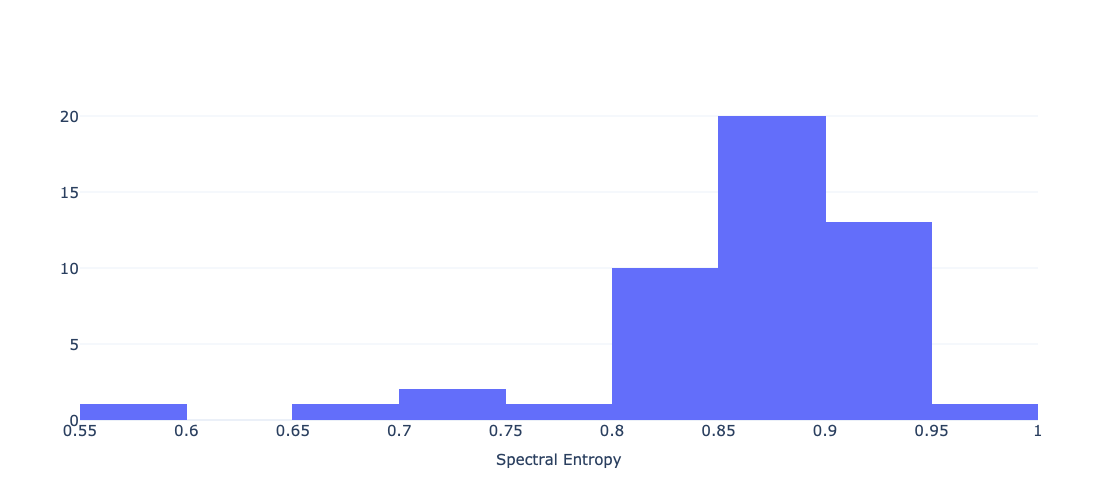

In [12]:
#Calculate and plot Spectral Entropy for Residuals:
from src.forecastability.entropy import spectral_entropy
import cmath
rspe_list = []
for var in range(len(col_list)):
    if col_list[var] in list(residuals_df.columns.values):
        index = list(residuals_df.columns.values).index(col_list[var])
        med = statistics.median(residuals_df[residuals_df.columns.values[index]])
        if med == 0:
            rspe_list.append(np.nan)
        else:
            rspe = spectral_entropy(residuals_df[residuals_df.columns.values[index]], axis=-1)
            rspe_list.append(rspe)
    else:
        rspe_list.append(10)               
rspe_series = pd.Series(rspe_list)
rspe_series = rspe_series.to_numpy()
rspe_series = rspe_series.real
rspe_list = list(rspe_series)
rspe_series = pd.Series(rspe_list)
orig_rspe_list = rspe_list.copy()
for ele in range(len(rspe_list)):
    if rspe_list[ele] == 10:
        rspe_list[ele] = np.nan
    if rspe_list[ele] > 1:
        rspe_list[ele] = np.nan
    if rspe_list[ele] < 0:
        rspe_list[ele] = np.nan
for ele in range(len(orig_rspe_list)):
    if orig_rspe_list[ele] == 10:
        orig_rspe_list[ele] = 'a'
rspe_series_init = pd.Series(rspe_list)
rspe_list = []
rspe_drop_list = []
for ele in range(len(rspe_series_init)):
    val = rspe_series_init.iloc[ele]
    if not pd.isnull(val):
        rspe_list.append(val)
    else:
        rspe_drop_list.append(ele)
rspe_series = pd.Series(rspe_list)
print('No. included: ', len(rspe_list))
print('No. original: ', (len(rspe_series_init) - (len(col_list) - len(list(residuals_df.columns.values)))))
fig = px.histogram(x=rspe_series, title="Distribution of Spectral Entropy")
fig = format_plot(fig, xlabel="Spectral Entropy", ylabel="")
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_RSE.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/entropy.py
#Accessed 02/07/2024

## Kaboudan Metric

Define functions for Kaboudan Metric:

In [13]:
#Define functions for Kaboudan Metric:
import random
import warnings

import numpy as np
from darts import TimeSeries


def sse(y_true: np.ndarray, y_pred: np.ndarray):
    # y_true, y_pred = _remove_nan_union(y_true, y_pred)
    return np.sum((y_true - y_pred) ** 2)


def block_shuffle(x, num_blocks):
    sh_array = np.array_split(x, num_blocks)
    random.shuffle(sh_array)
    return np.concatenate(sh_array)


def _backtest(model, x, backtesting_start, n_folds):
    history_len = int(len(x) * backtesting_start)
    train_x = x[:history_len]
    test_x = x[history_len:]
    blocks = np.array_split(test_x, n_folds)
    metric_l = []
    for i, block in enumerate(blocks):
        x_ = TimeSeries.from_values(train_x)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            model.fit(x_)
        y_pred = model.predict(len(block))
        metric_l.append(sse(block, np.squeeze(y_pred.data_array().values)))
        if i < len(blocks) - 1:
            train_x = np.concatenate([train_x, block])
    return np.mean(metric_l) if len(metric_l) > 1 else metric_l[0]


def kaboudan_metric(x, model, block_size=5, backtesting_start=0.5, n_folds=1):
    sse_before = _backtest(model, x, backtesting_start, n_folds)
    x_shuffled = block_shuffle(x, num_blocks=len(x) // block_size)
    sse_after = _backtest(model, x_shuffled, backtesting_start, n_folds)
    return 1 - (sse_before / sse_after)


def modified_kaboudan_metric(x, model, block_size=5, backtesting_start=0.5, n_folds=1):
    sse_before = _backtest(model, x, backtesting_start, n_folds)
    x_shuffled = block_shuffle(x, num_blocks=len(x) // block_size)
    sse_after = _backtest(model, x_shuffled, backtesting_start, n_folds)
    return np.clip(1 - np.sqrt(sse_before / sse_after), 0, None)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 02/07/2024

Calculate and plot Kaboudan Metric:

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transp

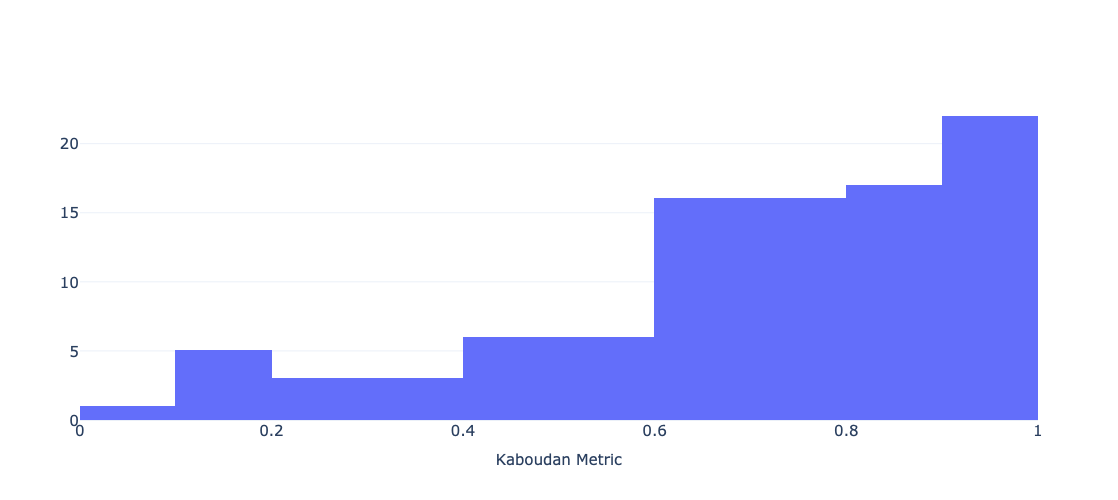

In [14]:
#Calculate and plot Kaboudan Metric:
kb_list = []
for var in range(len(col_list)):
    if seasonal_period_list[var] != 'not seasonal':
        model = Theta(theta=3, seasonality_period=seasonal_period_list[var], season_mode=SeasonalityMode.ADDITIVE)
    else:
        model = Theta(theta=3, seasonality_period=0, season_mode=SeasonalityMode.ADDITIVE)
    med = statistics.median(ts_df[col_list[var]])
    if med == 0:
        kb_list.append(np.nan)
    else:
        b = 114/len(ts_df[col_list[var]]) #training data in train-test split (see baseline forecast
        #notebook) is 114 samples
        kb = kaboudan_metric(ts_df[col_list[var]], model, backtesting_start=b)
        kb_list.append(kb)
orig_kb_list = kb_list.copy()
for ele in range(len(kb_list)):
    if kb_list[ele] > 1:
        kb_list[ele] = np.nan
    if kb_list[ele] < 0:
        kb_list[ele] = np.nan
kb_series_init = pd.Series(kb_list)
kb_list = []
kb_drop_list = []
for ele in range(len(kb_series_init)):
    val = kb_series_init.iloc[ele]
    if not pd.isnull(val):
        kb_list.append(val)
    else:
        kb_drop_list.append(ele)
kb_series = pd.Series(kb_list)
fig = px.histogram(x=kb_series, title="Distribution of Kaboudan Metric")
fig = format_plot(fig, xlabel="Kaboudan Metric", ylabel="")
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_KM.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 02/07/2024

In [15]:
print('No. included: ', len(kb_list))
print('No. original: ', len(kb_series_init))

No. included:  95
No. original:  140


Calculate and plot Modified Kaboudan Metric:

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transp

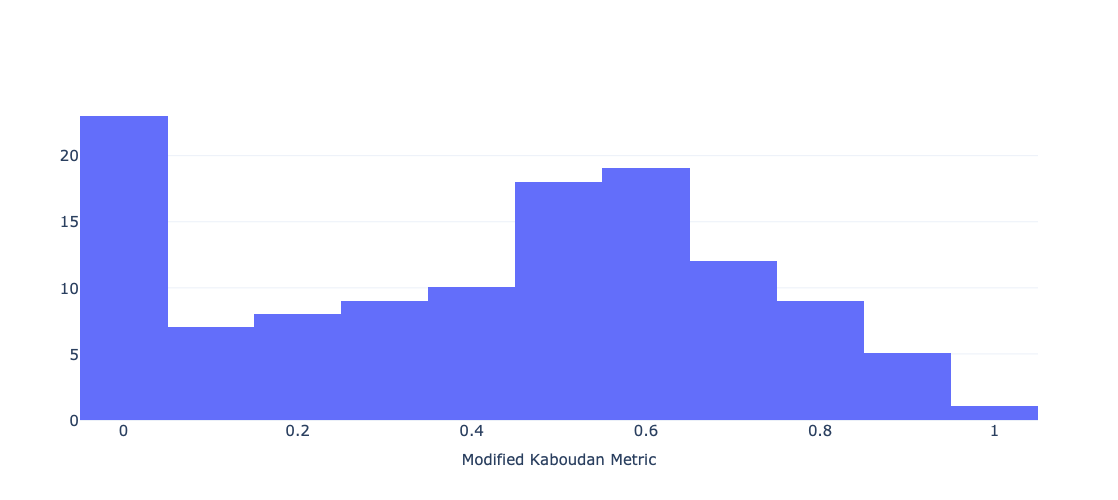

In [16]:
#Calculate and plot Modified Kaboudan Metric:
mkb_list = []
for var in range(len(col_list)):
    if seasonal_period_list[var] != 'not seasonal':
        model = Theta(theta=3, seasonality_period=seasonal_period_list[var], season_mode=SeasonalityMode.ADDITIVE)
    else:
        model = Theta(theta=3, seasonality_period=0, season_mode=SeasonalityMode.ADDITIVE)
    med = statistics.median(ts_df[col_list[var]])
    if med == 0:
        mkb_list.append(np.nan)
    else:
        b = 114/len(ts_df[col_list[var]]) #training data in train-test split (see baseline forecast
        #notebook) is 114 samples
        mkb = modified_kaboudan_metric(ts_df[col_list[var]], model, backtesting_start=b)
        mkb_list.append(mkb)
orig_mkb_list = mkb_list.copy()
for ele in range(len(mkb_list)):
    if mkb_list[ele] > 1:
        mkb_list[ele] = np.nan
    if mkb_list[ele] < 0:
        mkb_list[ele] = np.nan
mkb_series_init = pd.Series(mkb_list)
mkb_list = []
for ele in range(len(mkb_series_init)):
    val = mkb_series_init.iloc[ele]
    if not pd.isnull(val):
        mkb_list.append(val)
mkb_series = pd.Series(mkb_list)
fig = px.histogram(x=mkb_series, title="Distribution of Modified Kaboudan Metric")
fig = format_plot(fig, xlabel="Modified Kaboudan Metric", ylabel="")
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_MKM.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 02/07/2024

In [17]:
print('No. included: ', len(mkb_list))
print('No. original: ', len(mkb_series_init))

No. included:  121
No. original:  140


## Create dataframe of Forecastability metrics and calculate metric Rank Correlation

Calculate the rank of each variable according to these metrics and then calculate a Spearman's Correlation on these ranks within the different metrics to find out how similar these metrics are:

In [18]:
var_series = pd.Series(col_list)
data_list = [var_series, cov_series_init, rv_series_init, spe_series_init, rspe_series_init, kb_series_init, mkb_series_init]
columns_list = ['Variable', 'CV', 'RV', 'Spectral Entropy', 'Residual Spectral Entropy', 'Kaboudan Metric', 'Modified Kaboudan Metric']
for data in range(len(data_list)):
    data_list[data].name = columns_list[data]
forecastability_df = pd.concat(data_list, axis=1)

In [19]:
forecastability_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Variable                   140 non-null    object 
 1   CV                         61 non-null     float64
 2   RV                         49 non-null     float64
 3   Spectral Entropy           78 non-null     float64
 4   Residual Spectral Entropy  49 non-null     float64
 5   Kaboudan Metric            95 non-null     float64
 6   Modified Kaboudan Metric   121 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.8+ KB


In [20]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/forecastability_df.pik'
with open(file, 'wb') as f:
       pickle.dump(forecastability_df, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      forecastability_df = pickle.load(f) #load pickle file 'file' into variable

Define function for Loading Plots:

In [21]:
#define function for Loading Plots:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def biplot(item_metrics_df, features, filename, title="Loading Plot"):
    X = item_metrics_df[features].dropna()
    scaler = StandardScaler()
    scaler.fit(X)
    X=scaler.transform(X)
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(X)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    xs = components[:,0]
    ys = components[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xl = loadings[:,0]
    yl = loadings[:,1]
    scalex_loading = 1.0/(xl.max() - xl.min())
    scaley_loading = 1.0/(yl.max() - yl.min())
    fig = px.scatter(x=xs * scalex, y=ys * scaley, opacity=0, template="plotly_white")
    for i, feature in enumerate(features):
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=xl[i]* scalex_loading,
            y1=yl[i]* scaley_loading,
            line=dict(color="indigo",
                width=2,
                dash="dot")
        )
        fig.add_annotation(
            x=xl[i]* scalex_loading,
            y=yl[i]* scaley_loading,
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text= feature, #"<b>"+feature+"</b>",
            font=dict(
            family="Open Sans, sans serif",
            size=16,
            color="MediumPurple"
            ),
        )
    fig.update_layout(title_text=title, title_x=0.5)
    fig.write_image(filename)
    fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

In [22]:
def calc_rank(rank_df):
    for col in ['CV', 'RV', 'Spectral Entropy', 'Residual Spectral Entropy']:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['Kaboudan Metric', 'Modified Kaboudan Metric']:
        rank_df[col] = rank_df[col].rank(ascending=False)

    return rank_df

item_rankings = calc_rank(forecastability_df.drop(columns="Variable"))
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

In [23]:
corr_df = item_rankings.corr(method='spearman')
# corr_df.style.background_gradient(cmap='coolwarm')
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

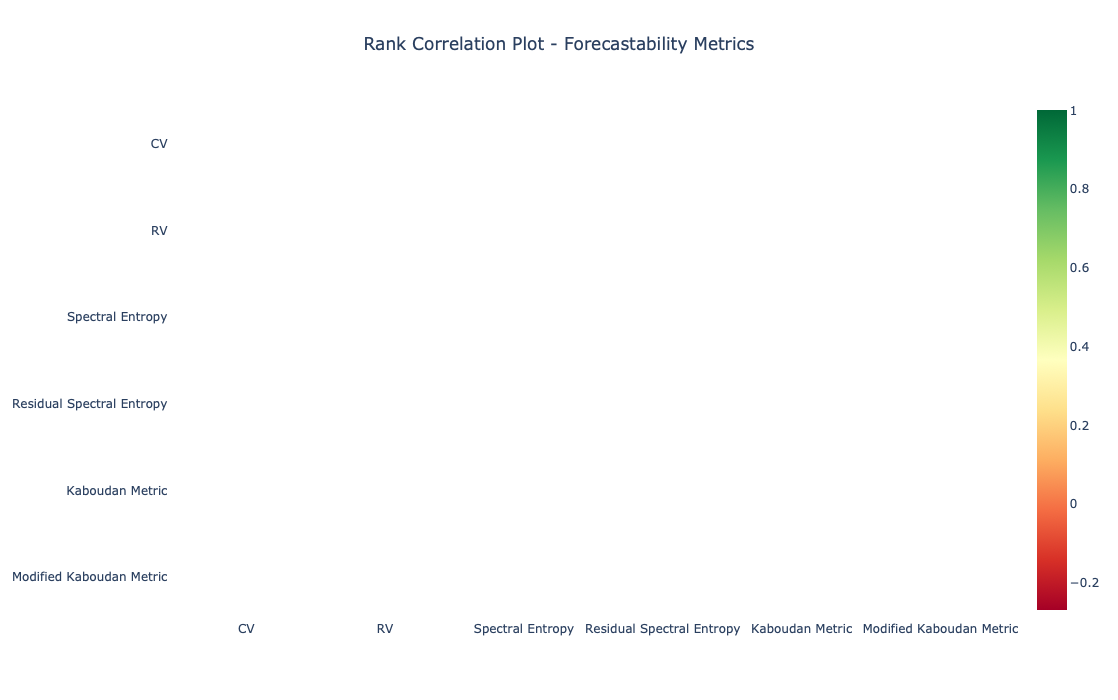

In [24]:
import plotly.figure_factory as ff

# mask = np.triu(np.ones_like(corr_df, dtype=bool))
# df_mask = corr_df.mask(mask).round(2)
df_mask = corr_df.round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""

fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

## Rank Correlation of Forecastability vs Forecast Metrics

- Merge the metrics calculated using the baseline forecasts with the forecastability metrics and calculate a rank correlation to see which of these metrics correlates with the baseline error metrics.

FFT val metrics:

In [25]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/forecastability_df.pik'
# with open(file, 'wb') as f:
#        pickle.dump(forecastability_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     forecastability_df = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/baseline_forecasts_baseline_val_metrics.pik'
# with open(file, 'wb') as f:
#        pickle.dump(base_metric_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     base_metric_df = pickle.load(f) #load pickle file 'file' into variable
forecastability_df = forecastability_df.merge(base_metric_df[base_metric_df.Algorithm=="FFT"], on="Variable", how='inner')

In [26]:
def calc_rank(rank_df):
    for col in ['CV', 'RV', 'Spectral Entropy', 'Residual Spectral Entropy']:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['Kaboudan Metric', 'Modified Kaboudan Metric', "MAE", "MSE", "MASE"]:
        rank_df[col] = rank_df[col].rank(ascending=False)
    
    for col in ["Forecast Bias"]:
        rank_df[col] = np.abs(rank_df[col]).rank(ascending=False)

    return rank_df

item_rankings =calc_rank(forecastability_df.drop(columns=["Variable", 'Algorithm']))
corr_df = item_rankings.corr(method='spearman')
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

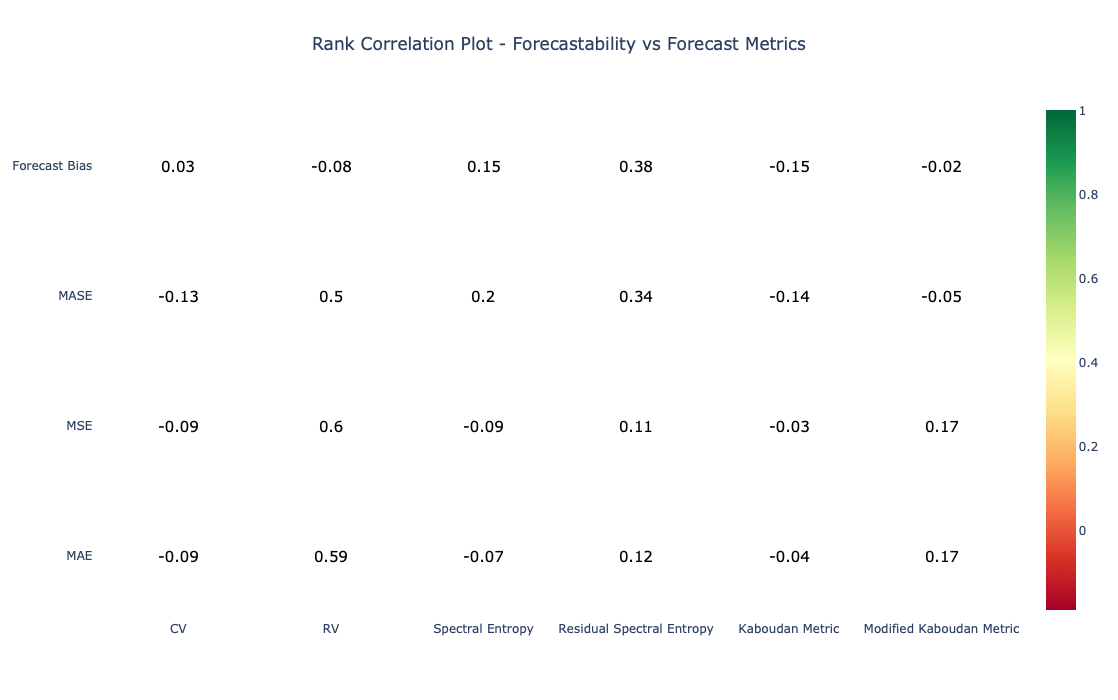

In [27]:
import plotly.figure_factory as ff

mask = np.zeros_like(corr_df).astype(bool)
mask[:5,:] = True
df_mask = corr_df.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability vs Forecast Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    # yaxis_autorange='reversed',
    xaxis_range=[-0.5,5.5],
    yaxis_range=[5.5, 9.5]
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    fig.layout.annotations[i]['font']['color']="#000000"
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_fft_val_metrics.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

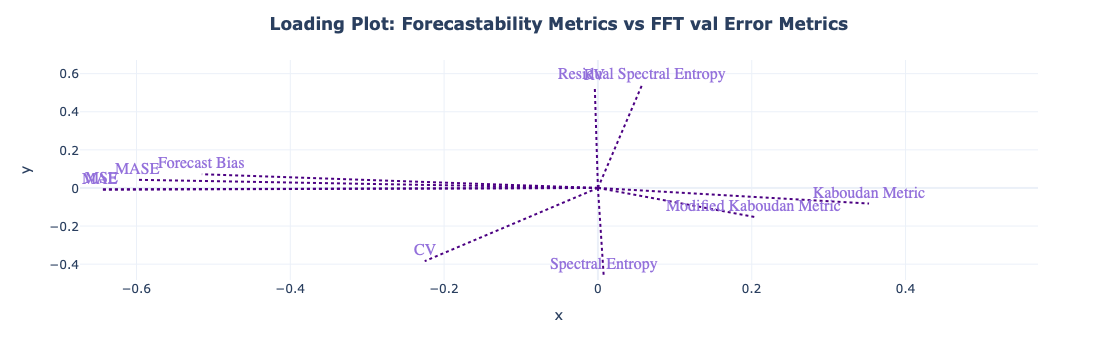

In [28]:
#Replace nans with 0 in item_rankings for pca (metric values of nan -> metric value of zero)
for row in range(len(item_rankings)):
    for col in range(len(list(item_rankings.columns.values))):
        if pd.isnull(item_rankings[item_rankings.columns.values[col]][row]):
            item_rankings[item_rankings.columns.values[col]][row] = 0            
filename = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_fft_val_metrics_loading_plot.png'
biplot(item_rankings, features=['Spectral Entropy',"Residual Spectral Entropy",
       'Modified Kaboudan Metric', 'CV',"Kaboudan Metric",
       'RV', "MAE", "MSE", "MASE","Forecast Bias"], title="<b>Loading Plot: Forecastability Metrics vs FFT val Error Metrics</b>", filename=filename)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

Theta val metrics:

In [29]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/forecastability_df.pik'
# with open(file, 'wb') as f:
#        pickle.dump(forecastability_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     forecastability_df = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/baseline_forecasts_baseline_val_metrics.pik'
# with open(file, 'wb') as f:
#        pickle.dump(base_metric_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     base_metric_df = pickle.load(f) #load pickle file 'file' into variable
forecastability_df = forecastability_df.merge(base_metric_df[base_metric_df.Algorithm=="Theta"], on="Variable", how='inner')

In [30]:
def calc_rank(rank_df):
    for col in ['CV', 'RV', 'Spectral Entropy', 'Residual Spectral Entropy']:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['Kaboudan Metric', 'Modified Kaboudan Metric', "MAE", "MSE", "MASE"]:
        rank_df[col] = rank_df[col].rank(ascending=False)
    
    for col in ["Forecast Bias"]:
        rank_df[col] = np.abs(rank_df[col]).rank(ascending=False)

    return rank_df

item_rankings =calc_rank(forecastability_df.drop(columns=["Variable", 'Algorithm']))
corr_df = item_rankings.corr(method='spearman')
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

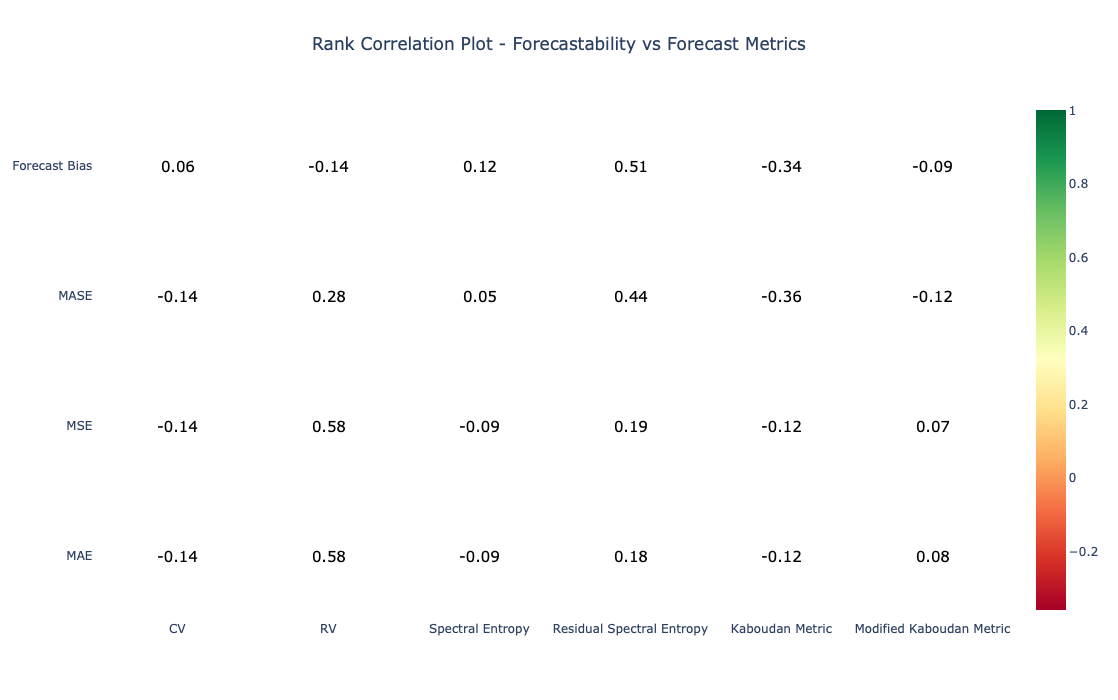

In [31]:
import plotly.figure_factory as ff

mask = np.zeros_like(corr_df).astype(bool)
mask[:5,:] = True
df_mask = corr_df.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability vs Forecast Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    # yaxis_autorange='reversed',
    xaxis_range=[-0.5,5.5],
    yaxis_range=[5.5, 9.5]
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    fig.layout.annotations[i]['font']['color']="#000000"
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_theta_val_metrics.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

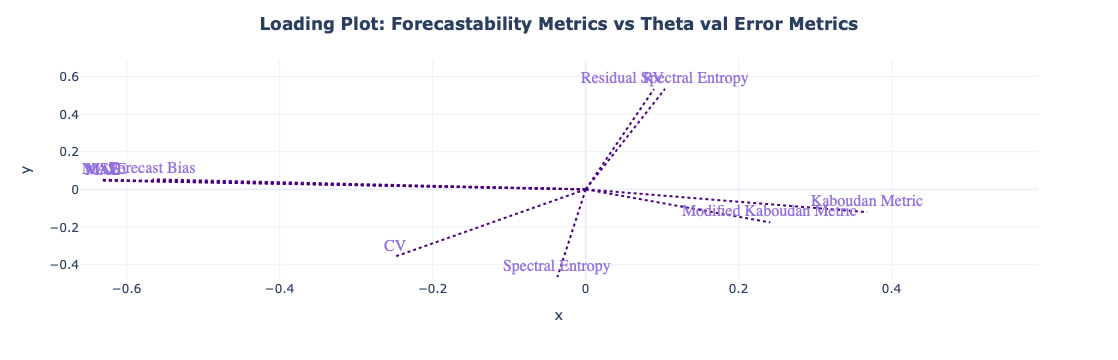

In [32]:
#Replace nans with 0 in item_rankings for pca (metric values of nan -> metric value of zero)
for row in range(len(item_rankings)):
    for col in range(len(list(item_rankings.columns.values))):
        if pd.isnull(item_rankings[item_rankings.columns.values[col]][row]):
            item_rankings[item_rankings.columns.values[col]][row] = 0
filename = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_theta_val_metrics_loading_plot.png'
biplot(item_rankings, features=['Spectral Entropy',"Residual Spectral Entropy",
       'Modified Kaboudan Metric', 'CV',"Kaboudan Metric",
       'RV', "MAE", "MSE", "MASE","Forecast Bias"], title="<b>Loading Plot: Forecastability Metrics vs Theta val Error Metrics</b>", filename=filename)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

FFT test metrics:

In [33]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/forecastability_df.pik'
# with open(file, 'wb') as f:
#        pickle.dump(forecastability_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     forecastability_df = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/baseline_forecasts_baseline_test_metrics.pik'
# with open(file, 'wb') as f:
#        pickle.dump(base_metric_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     base_metric_df = pickle.load(f) #load pickle file 'file' into variable
forecastability_df = forecastability_df.merge(base_metric_df[base_metric_df.Algorithm=="FFT"], on="Variable", how='inner')

In [34]:
def calc_rank(rank_df):
    for col in ['CV', 'RV', 'Spectral Entropy', 'Residual Spectral Entropy']:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['Kaboudan Metric', 'Modified Kaboudan Metric', "MAE", "MSE", "MASE"]:
        rank_df[col] = rank_df[col].rank(ascending=False)
    
    for col in ["Forecast Bias"]:
        rank_df[col] = np.abs(rank_df[col]).rank(ascending=False)

    return rank_df

item_rankings =calc_rank(forecastability_df.drop(columns=["Variable", 'Algorithm']))
corr_df = item_rankings.corr(method='spearman')
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

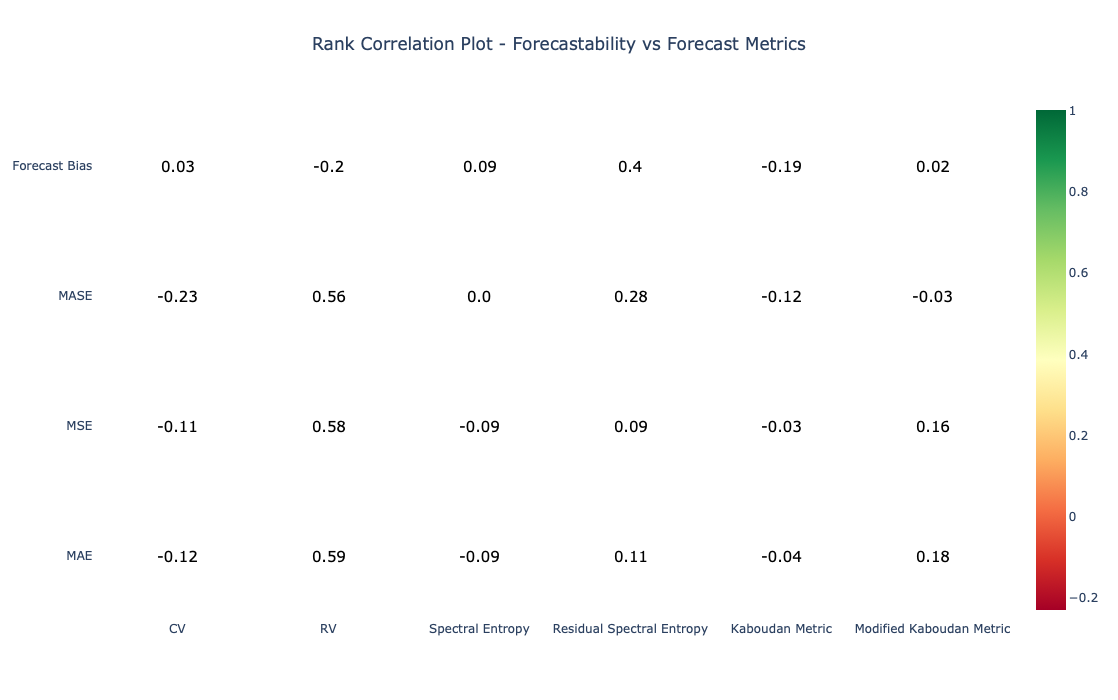

In [35]:
import plotly.figure_factory as ff

mask = np.zeros_like(corr_df).astype(bool)
mask[:5,:] = True
df_mask = corr_df.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability vs Forecast Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    # yaxis_autorange='reversed',
    xaxis_range=[-0.5,5.5],
    yaxis_range=[5.5, 9.5]
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    fig.layout.annotations[i]['font']['color']="#000000"
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_fft_test_metrics.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

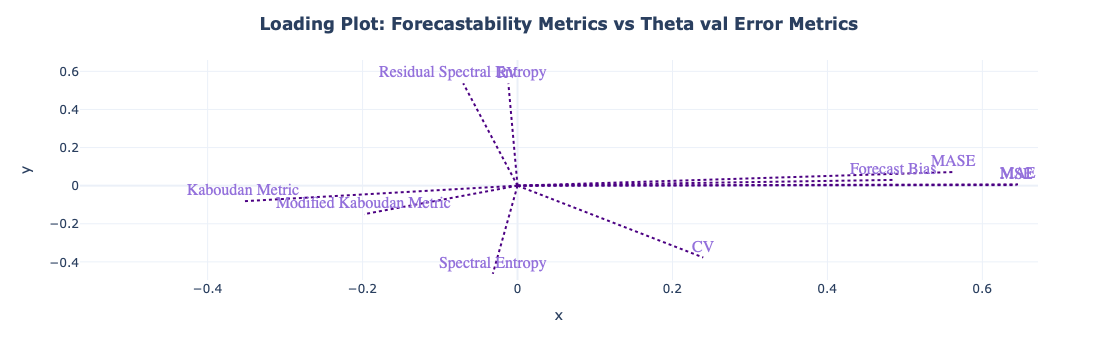

In [36]:
#Replace nans with 0 in item_rankings for pca (metric values of nan -> metric value of zero)
for row in range(len(item_rankings)):
    for col in range(len(list(item_rankings.columns.values))):
        if pd.isnull(item_rankings[item_rankings.columns.values[col]][row]):
            item_rankings[item_rankings.columns.values[col]][row] = 0
filename = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_fft_test_metrics_loading_plot.png'
biplot(item_rankings, features=['Spectral Entropy',"Residual Spectral Entropy",
       'Modified Kaboudan Metric', 'CV',"Kaboudan Metric",
       'RV', "MAE", "MSE", "MASE","Forecast Bias"], title="<b>Loading Plot: Forecastability Metrics vs Theta val Error Metrics</b>", filename=filename)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

Theta test metrics:

In [37]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/forecastability_df.pik'
# with open(file, 'wb') as f:
#        pickle.dump(forecastability_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     forecastability_df = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/baseline_forecasts_baseline_test_metrics.pik'
# with open(file, 'wb') as f:
#        pickle.dump(base_metric_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     base_metric_df = pickle.load(f) #load pickle file 'file' into variable
forecastability_df = forecastability_df.merge(base_metric_df[base_metric_df.Algorithm=="Theta"], on="Variable", how='inner')

In [38]:
def calc_rank(rank_df):
    for col in ['CV', 'RV', 'Spectral Entropy', 'Residual Spectral Entropy']:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['Kaboudan Metric', 'Modified Kaboudan Metric', "MAE", "MSE", "MASE"]:
        rank_df[col] = rank_df[col].rank(ascending=False)
    
    for col in ["Forecast Bias"]:
        rank_df[col] = np.abs(rank_df[col]).rank(ascending=False)

    return rank_df

item_rankings =calc_rank(forecastability_df.drop(columns=["Variable", 'Algorithm']))
corr_df = item_rankings.corr(method='spearman')
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

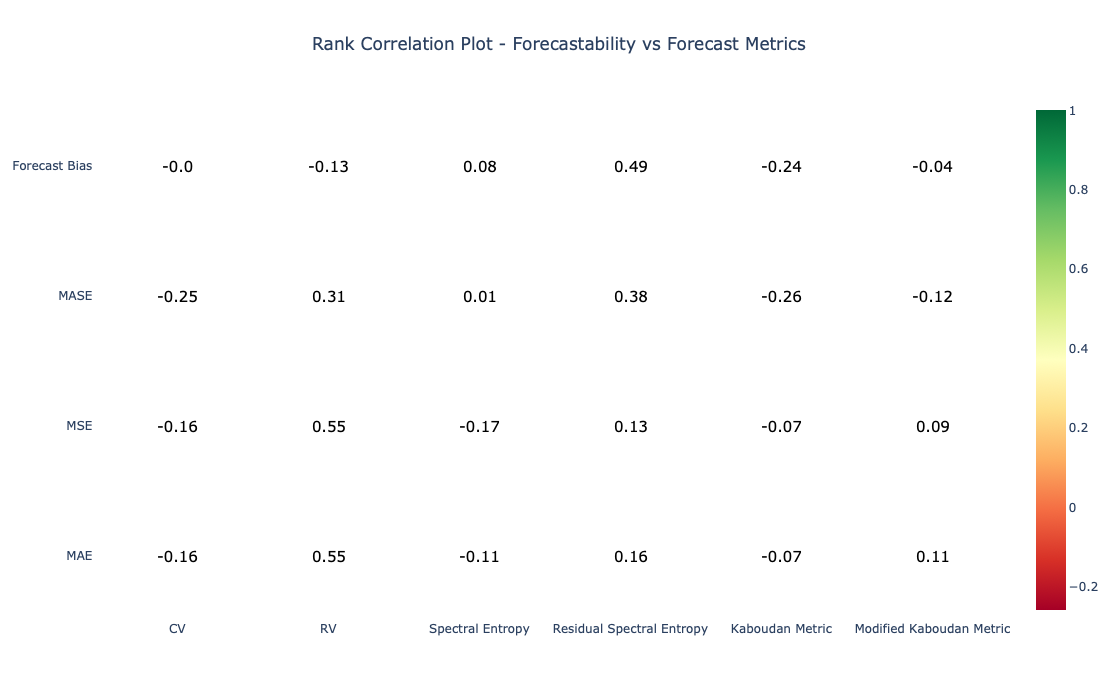

In [39]:
import plotly.figure_factory as ff

mask = np.zeros_like(corr_df).astype(bool)
mask[:5,:] = True
df_mask = corr_df.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability vs Forecast Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    # yaxis_autorange='reversed',
    xaxis_range=[-0.5,5.5],
    yaxis_range=[5.5, 9.5]
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    fig.layout.annotations[i]['font']['color']="#000000"
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_theta_test_metrics.png")
fig.show()
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

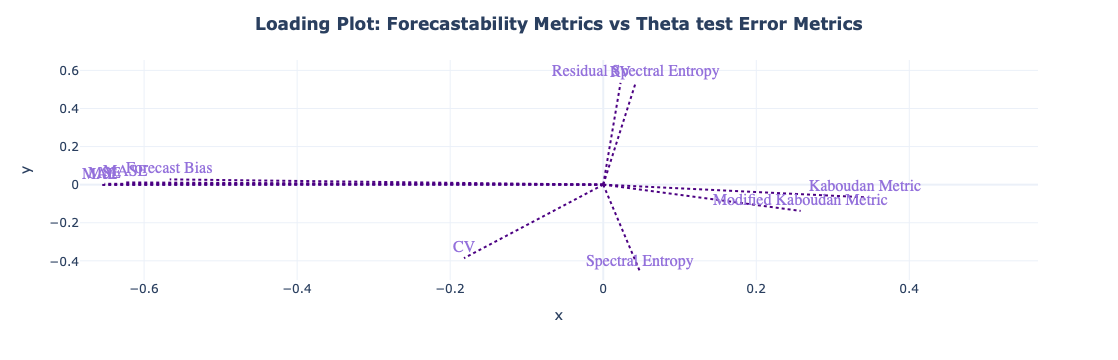

In [40]:
#Replace nans with 0 in item_rankings for pca (metric values of nan -> metric value of zero)
for row in range(len(item_rankings)):
    for col in range(len(list(item_rankings.columns.values))):
        if pd.isnull(item_rankings[item_rankings.columns.values[col]][row]):
            item_rankings[item_rankings.columns.values[col]][row] = 0
filename = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/forecastability/dataset_rank_correlation_forecastability_vs_theta_test_metrics_loading_plot.png'
biplot(item_rankings, features=['Spectral Entropy',"Residual Spectral Entropy",
       'Modified Kaboudan Metric', 'CV',"Kaboudan Metric",
       'RV', "MAE", "MSE", "MASE","Forecast Bias"], title="<b>Loading Plot: Forecastability Metrics vs Theta test Error Metrics</b>", filename=filename)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/src/forecastability/kaboudan.py
#Accessed 03/07/2024

## DROP VARIABLES THAT ARE NOT FORECASTABLE

In [41]:
print(cov_series_init)
print(rv_series_init)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
135         NaN
136    2.238599
137    4.210490
138         NaN
139    2.806480
Name: CV, Length: 140, dtype: float64
0      0.061660
1      0.088601
2      0.076875
3           NaN
4           NaN
         ...   
135    0.844163
136         NaN
137         NaN
138    0.815291
139         NaN
Name: RV, Length: 140, dtype: float64


In [53]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/outlier_treated_ts_df_2.pik'
# with open(file, 'wb') as f:
#        pickle.dump(ts_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     ts_df = pickle.load(f) #load pickle file 'file' into variable
for col in range(len(list(ts_df.columns.values)[:140])):
    ts_df[list(ts_df.columns.values)[col]] = pd.to_numeric(ts_df[list(ts_df.columns.values)[col]])
count = 0
for col in range(len(list(ts_df.columns.values)[:140])):
    cov = calc_cov(ts_df[list(ts_df.columns.values)[col]])
    if cov > 100:
        count += 1
print(count)
count = 0
for ele in range(len(orig_rv_list)):
    if type(orig_rv_list[ele]) != str:
        if orig_rv_list[ele] > 100:
            count += 1
print(count)

0
0


/tmp/ipykernel_40627/1370289694.py:19: RuntimeWarning:

invalid value encountered in scalar divide



- CV < 0.49 considered acceptable (Modern Time Series With Python (Manu Joseph, 2022))
- Therefore, drop variables found with RV and CV >= 49 within the 0 - 100 range (all raw data positive and raw data C.o.V always < 100, variance cannot be negative (1), all RV < 100 (see cell above), so negative CV or RV (unexplained variance (2)) and > 100 in data made stationary not meaningful to make decisions on)
- Dropping these 4 variables produces good results by MAE, MSE, MASE, Forecast Bias (see notebooks 10 and 11); don't want to drop more based on variability/unexplained variance if not necessary as this would decrease the number of features and unnecessarily increase the bias in the model (3)   

(1) - https://statproofbook.github.io/P/var-nonneg.html - Accessed 25/07/2024   
(2) - https://www.statisticshowto.com/residual-variance/ - Accessed 25/07/2024, original source:  Methodology for Genetic Studies of Twins and Families (Nato Science Series D) (Neale, M. & Cardon, L., 2003)   
(3) - https://cs229.stanford.edu/summer2020/BiasVarianceAnalysis.pdf - Accessed 25/07/2024   

In [43]:
drop_list_cov = []
for row in range(len(cov_series_init)):
    if not pd.isnull(cov_series_init[row]):
        if cov_series_init[row] >= 49: #could reduce cutoff to 20 or 30, or as low as 5
            drop_list_cov.append(row)
drop_list_rv = []
for row in range(len(rv_series_init)):
    if not pd.isnull(rv_series_init[row]):
        if rv_series_init[row] >= 49: #could reduce cutoff to 20 or 30, or as low as 5
            drop_list_rv.append(row)
print(drop_list_cov)
print(len(drop_list_cov))
print(drop_list_rv)
print(len(drop_list_rv))
drop_list_cov = []
for row in range(len(cov_series_init)):
    if not pd.isnull(cov_series_init[row]):
        if cov_series_init[row] >= 5: #could reduce cutoff to 20 or 30, or as low as 5
            #if at >= 5, plenty in drop list for cov)
            drop_list_cov.append(row)
drop_list_rv = []
for row in range(len(rv_series_init)):
    if not pd.isnull(rv_series_init[row]):
        if rv_series_init[row] >= 4: #1st droppable [seasonal] variables by rv added to 
            #drop list when < 5 (at >= 4), plenty for cov at >= 4 and >= 5, would have max possible 
            #similar variability and unexplained variance range if cutoff was 
            #at >= 5 for both - if same have variability in non-seasonal variables in a similar
            #range to unexplained variance in seasonal variables
            drop_list_rv.append(row)
print('')
print(drop_list_cov)
print(len(drop_list_cov))
print(drop_list_rv)
print(len(drop_list_rv))
drop_list_rv = []
for row in range(len(rv_series_init)):
    if not pd.isnull(rv_series_init[row]):
        if rv_series_init[row] >= 5:
            drop_list_rv.append(row)
print('')
print(drop_list_rv)
print(len(drop_list_rv))

[47, 85, 100, 102]
4
[]
0

[36, 45, 47, 57, 63, 64, 67, 69, 70, 72, 76, 77, 82, 85, 89, 91, 95, 97, 98, 100, 102, 105, 107, 111, 127, 129, 130]
27
[94]
1

[]
0


Drop variables at 47, 85, 100, 102

# COMMENTS AND CONCLUSIONS:

- ascertained which variables forecastable and which not by CV and RV metrics

- Spectral Entropy, Residual Spectral Entropy and Kaboudan Metric on the higher side (predominantly 0.7 ≤ x ≤ 1), Modified Kaboudan Metric more evenly distributed from 0 to 1
  
- Calculated the rank of each variable according to these metrics and then calculate a Spearman's Correlation on these ranks within the different metrics to find out how similar these metrics are: Kaboudan Metric and Modified Kaboudan Metric most similar by Spearman's Correlation



- Merged the metrics calculated using the baseline forecasts with the forecastability metrics and calculate a rank correlation to see which of these metrics correlates with the baseline error metrics:
    - MAE, MSE and MASE strongly correlated with RV in FFT val set baseline forecasts, MAE and MSE with RV in Theta val set baseline forecasts  
    - MAE, MSE and MASE strongly correlated with RV in FFT test set baseline forecasts, MAE and MSE with RV in Theta test set baseline forecasts    
    - Forecast Bias correlated with Residual Spectral Entropy in Theta and FFT test and validation set baseline forecasts   